In [14]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr

In [15]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-77.90174759231485
SNR Threshold: 27


Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


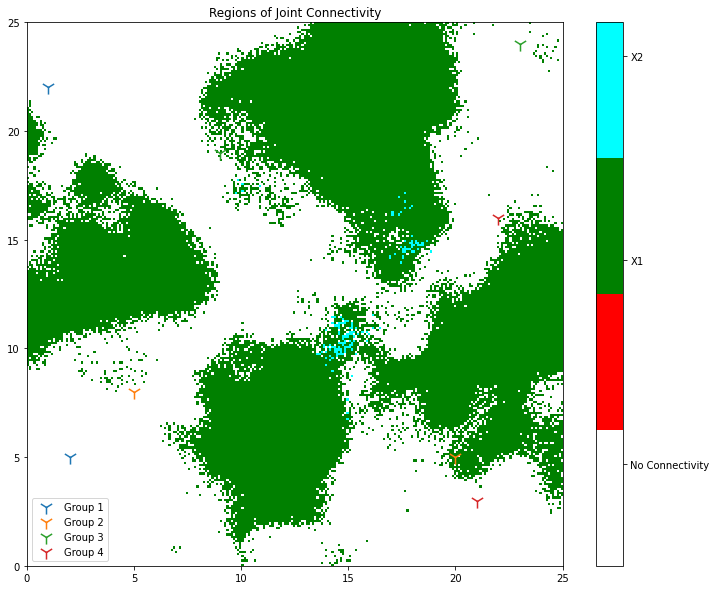

In [16]:
#Setup the system:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#8 remote stations
qBase = np.array([[2,5],[1,22],
                 [5,8],[20,5],
                 [9, 19],[23,24],
                 [21, 3],[22,16]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 25
x_min = 0
y_max = 25
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)

#now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(GAMMA_TH) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 1*cfs[2]*cfs[3]; r3 = 1*cfs[4]*cfs[5]; r4 = 1*cfs[6]*cfs[7];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3+r4, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(4):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), marker='1', s=200)
plt.legend()    
plt.show()

In [17]:
#Create the predicted channel
pct_sample = 0.005
n_samples = int(pct_sample*(x_max - x_min)*(y_max - y_min)*res**2)
print('Drawing %d samples from each region'%(n_samples))
pcs = []
for cc in ccs:
    xs, vals = cc.sampleChannel(n_samples)
    pcs.append(CC.PredictedChannel(cc.cp, cc.region, res, xs, vals))
    print('Completed PredictedChannel %d'%(len(pcs)))
#avoid collisions when saving this off
pcs2 = pcs
%store pcs2

Drawing 312 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
Completed PredictedChannel 3
Completed PredictedChannel 4
Completed PredictedChannel 5
Completed PredictedChannel 6
Completed PredictedChannel 7
Completed PredictedChannel 8
Stored 'pcs2' (list)


In [18]:
#%store -r pcs2
#pcs = pcs2

In [19]:
#now display the regions so we know if this is going to work for us
color_array=['white', 'blue', 'red', 'green', 'cyan']
#plot the connectivity fields
pfs = [pc.getPConField(GAMMA_TH) for pc in pcs]

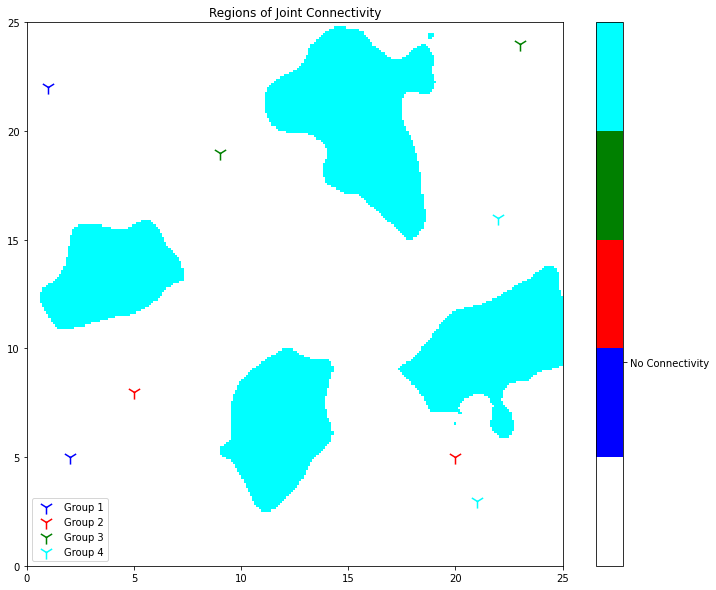

In [20]:

p_th = 0.95
for pc in pcs:
    pc.setPth(p_th)

r1 = 1*(pfs[0]*pfs[1]>p_th); r2 = 1*(pfs[2]*pfs[3]>p_th); r3 = 1*(pfs[4]*pfs[5]>p_th); r4 = 1*(pfs[6]*pfs[7]>p_th)
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3+r4, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(4):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [21]:
from importlib import reload 
reload(dtr)
# reload(MRP)
# reload(PS)
reload(PC)

<module 'pointcloud' from '/home/win/dev/CommMotionPlanning/python/touring_relay/../geometry/pointcloud.py'>

In [25]:
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)

p4 = [0.2, 0.1, 0.02]
pis = []
Xs = []
Ws =[]

npis = []
nXs = []
nWs =[]

all_els = []
els = np.ones(len(pcs)//2)/(beta*len(pcs))
sys = dtr.DTR(pcs, els, beta, th=GAMMA_TH)
for i in range(len(p4)):
    #make it easy to ensure stability by givein arrivals in terms of beta
    els = np.array([0.2/beta, 0.2/beta, 0.2/beta, p4[i]/beta])
    all_els.append(els)
    sys.ps.Ls = els
    W, pi, X = sys.optimize(x_opt_method=3, do_plot = False)
    pis.append(pi)
    Xs.append(X)
    Ws.append(W)
    nW, npi, nX = sys.naive_policy()
    npis.append(npi)
    nXs.append(nX)
    nWs.append(nW)
    print("============================================================")
    print("============================================================")
    print('Optimized:')
    print('\tPi: '+str(pi)+'\n\tRelay Positions: '+ str(X)+'\n\tWaiting Time: '+str(W))
    print('Naive:')
    print('\tPi: '+str(npi)+'\n\tRelay Positions: '+ str(nX)+'\n\tWaiting Time: '+str(nW))
    print("============================================================")
    print("============================================================")

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
7 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
14 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
8 total subregions
Optimized Policy Waiting Time: 126.3086
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 199 rows, 52 columns and 603 nonzeros
Model fingerprint: 0x84e9812e
Model has 6 quadratic constraints
Variable types: 14 continuous, 38 integer (38 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+04]
  QMatrix 


Cutting planes:
  Gomory: 7
  Implied bound: 2
  MIR: 4
  Flow cover: 8
  RLT: 14
  Relax-and-lift: 1
  BQP: 1
  PSD: 95

Explored 12353 nodes (142141 simplex iterations) in 15.64 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 1.55469 1.55521 1.56552 ... 2.18497

Optimal solution found (tolerance 1.00e-04)
Best objective 1.554688205098e+00, best bound 1.554588174305e+00, gap 0.0064%
Transition probabilities:  [0.11775682 0.39561697 0.17218437 0.31444184]
Points:  [[ 8.  12.9]
 [14.6 10.1]
 [17.  13.8]
 [15.9  9.5]]
Optimized Location Waiting Time: 61.4886
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 199 rows, 52 columns and 603 nonzeros
Model fingerprint: 0xca8f4896
Model has 6 quadratic constraints
Variable types: 14 continuous, 38 integer (38 binary)
Coefficient st

   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 199 rows, 52 columns and 603 nonzeros
Model fingerprint: 0x73e55c98
Model has 6 quadratic constraints
Variable types: 14 continuous, 38 integer (38 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [4e-02, 9e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 9 rows and 0 columns
Presolve time: 0.03s
Presolved: 286 rows, 78 columns, 1388 nonzeros
Presolved model has 26 bilinear constraint(s)
Variable types: 40 continuous, 38 integer (38 binary)

Root relaxation: objective 0.000000e+00, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000  

H   27    21                       2.2997125    0.00000   100%  13.9    0s
H   72    43                       1.9861872    0.00000   100%  14.1    0s
H  162    93                       1.9213458    0.00000   100%  16.4    1s
H 1020   335                       1.7707623    0.06880  96.1%  12.5    2s
H 1026   320                       1.7420861    0.25668  85.3%  12.4    2s
* 1383   395              86       1.7398519    0.35521  79.6%  11.1    2s
* 1390   377              85       1.7398443    0.35521  79.6%  11.0    2s
* 1393   360              85       1.7398442    0.35521  79.6%  11.0    2s
  4074   837    1.67921   37   25    1.73984    0.48325  72.2%   9.7    5s
 10804  1433    1.73845   34   25    1.73984    0.82723  52.5%   9.3   10s
H13755  1382                       1.7383782    1.03713  40.3%   9.2   12s
*16557  1308              69       1.7383437    1.29706  25.4%   9.1   14s
*16561  1306              69       1.7383412    1.29706  25.4%   9.1   14s
 17557  1310    1.44458  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   22          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   20          -    0.00000      -     -    0s
     0     0    0.00000    0   22          -    0.00000      -     -    0s
     0     0    0.00000    0   22          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   25          -    0.00000      -     -    0s
     0     0    0.00000    0   25          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
H    0     0           

Model fingerprint: 0x633c5fe3
Model has 6 quadratic constraints
Variable types: 14 continuous, 38 integer (38 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [2e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 9 rows and 0 columns
Presolve time: 0.03s
Presolved: 286 rows, 78 columns, 1388 nonzeros
Presolved model has 26 bilinear constraint(s)
Variable types: 40 continuous, 38 integer (38 binary)

Root relaxation: objective 0.000000e+00, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   22          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   20          -    0.00000      -     -    0s
     0     0    0.00000    0   22  


Cutting planes:
  Implied bound: 2
  PSD: 10

Explored 57763 nodes (411894 simplex iterations) in 37.88 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 1.96548 1.96548 1.96548 ... 2.03149

Optimal solution found (tolerance 1.00e-04)
Best objective 1.965479153215e+00, best bound 1.965287937044e+00, gap 0.0097%
Transition probabilities:  [0.22306501 0.45401686 0.23247013 0.09044801]
Points:  [[ 8.  12.9]
 [14.4 10.3]
 [17.  13.8]
 [15.9  9.5]]
Optimized Location Waiting Time: 31.9955
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 199 rows, 52 columns and 603 nonzeros
Model fingerprint: 0x5b1648dd
Model has 6 quadratic constraints
Variable types: 14 continuous, 38 integer (38 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   22          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   20          -    0.00000      -     -    0s
     0     0    0.00000    0   22          -    0.00000      -     -    0s
     0     0    0.00000    0   22          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   25          -    0.00000      -     -    0s
     0     0    0.00000    0   25          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
     0     0    0.00000    0   24          -    0.00000      -     -    0s
H    0     0           

In [26]:
for i in range(len(p4)):
    print("============================================================")
    print("============================================================")
    print('Arrival Rates: ' + str(all_els[i]))
    print('Routing Policy')
    print('\tOptimal: '+str(pis[i])+'\tNaive: ' + str(npis[i]))
    print('Waiting Time')
    print('\tOptimal: %.2f\tNaive: %.2f\tDifference: %.2f'%(Ws[i], nWs[i], nWs[i] - Ws[i]) )
    
print("============================================================")
print("============================================================")

Arrival Rates: [2.4 2.4 2.4 2.4]
Routing Policy
	Optimal: [0.11775682 0.39561696 0.17218437 0.31444184]	Naive: [0.25 0.25 0.25 0.25]
Waiting Time
	Optimal: 61.49	Naive: 69.34	Difference: 7.85
Arrival Rates: [2.4 2.4 2.4 1.2]
Routing Policy
	Optimal: [0.13396879 0.43400675 0.19650622 0.23551824]	Naive: [0.28571429 0.28571429 0.28571429 0.14285714]
Waiting Time
	Optimal: 42.51	Naive: 48.83	Difference: 6.32
Arrival Rates: [2.4  2.4  2.4  0.24]
Routing Policy
	Optimal: [0.17316039 0.46828029 0.25155003 0.10700928]	Naive: [0.32258065 0.32258065 0.32258065 0.03225806]
Waiting Time
	Optimal: 31.39	Naive: 39.49	Difference: 8.11


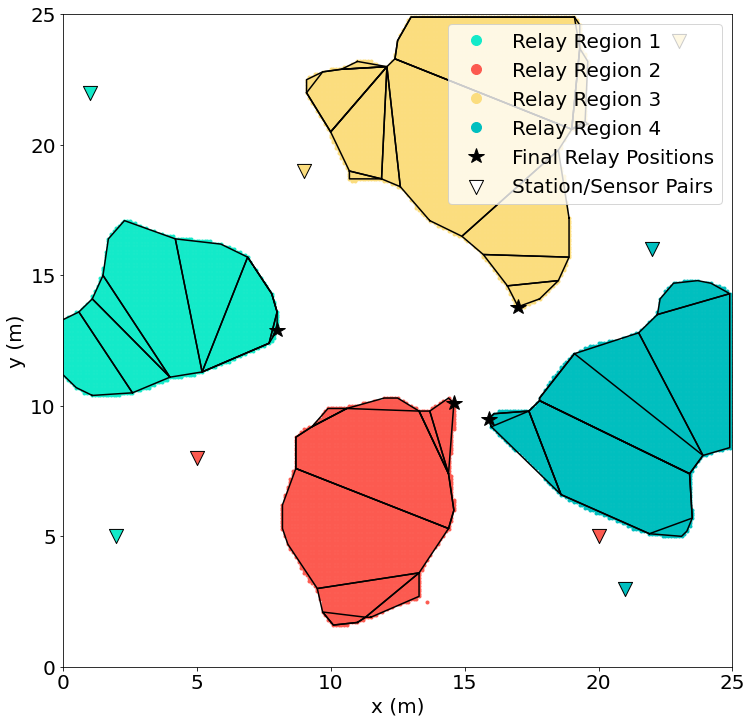

In [28]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(4):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')
pod_colors = []
x=Xs[0]
plt.plot(x[:,0], x[:,1], '*k', markersize=16, label='Final Relay Positions')
plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=fs)
plt.ylabel('y (m)', fontsize=fs)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_four_spread_%d_pth_%.2f_gammath_%d.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

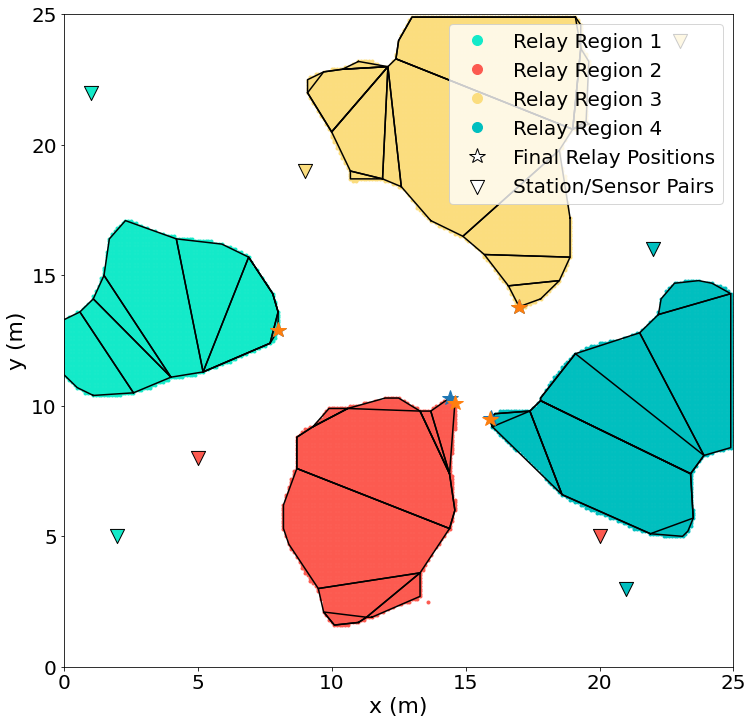

In [27]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(4):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')


x=Xs[2]
plt.plot(x[:,0], x[:,1], '*', markersize=16)
x= Xs[0]
plt.plot(x[:,0], x[:,1], '*', markersize=16)
#for the legend
plt.plot([-100], [100], '*', color='w', markeredgecolor='k', markersize=16, label='Final Relay Positions')
#ax = plt.gca()
#ax.annotate('')

plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=22)
plt.ylabel('y (m)', fontsize=22)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_four_spread_%d_pth_%.2f_gammath_%d_alt.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

In [ ]:
print(np.array([0.2/beta, 0.2/beta, p3[0]/beta]))
print(np.array([0.2/beta, 0.2/beta, p3[2]/beta]))

In [ ]:
beta